# Measuring Empowerment and Plasticity
After reading the _Plasticity as the Mirror of Empowerment_ paper, the rat and light rooms example immediately caught my eye as a place to measure empowerment and plasticity in this new manner. However, I initially encountered some hurdles when estimating information theoretic quantities (see appendix), so I started with an easier decision-making setting to debug.

In [1]:
# necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import src.info_theory as it

## 1. Bit World
This is the simplest possible decision-making setting I could think of where I could measure, play with, and debug empowerment and plasticity.

On each timestep, the environment emits a single bit observation from $ \mathcal{O} = \{0, 1\}$, and the agent responds with a single bit action from $\mathcal{A} = \{0, 1\}$. The environment randomly emits a bit, independent of the agent's action.

I want to create a _totally plastic agent_, whose decision-making is entirely shaped by the environment. This can simply be done with the policy $A_t = O_{t-1}$.

In [2]:
from src.environments.BitWorld import BitWorld
from src.info_theory import directed_info_approx_markov
from experiments.measure_FollowerAgent import agent_follow_obs, run_sim

env = BitWorld()
n_steps = 20
n_episodes = 10000

actions, observations = run_sim(agent_follow_obs, env, n_steps, n_episodes)

print("Computing Empowerment (A -> O)...")
emp = directed_info_approx_markov(actions, observations, k=2)
print(f"Estimated Empowerment: {emp:.4f} bits")

print("Computing Plasticity (O -> A)...")
plast = directed_info_approx_markov(observations, actions, k=2)
print(f"Estimated Plasticity: {plast:.4f} bits")

100%|██████████| 10000/10000 [00:00<00:00, 30267.35it/s]


Computing Empowerment (A -> O)...
Estimated Empowerment: 0.0048 bits
Computing Plasticity (O -> A)...
Estimated Plasticity: 19.9952 bits


This matches my intuition! My take on these numbers:
* $0 \, \text{bits}$ of empowerment makes sense, as no action the agent takes can influence the random bit emitted by the environment.
* We observe a plasticity of $\approx 20 \, \text{bits}$, as thats the amount of information from the environment that influenced the agent's decision making over our 21 step experiment ($O_0, A_0 \sim \mathcal{U}\{0,1\}$).

Studying this even further, Theorem 4.8 gives us an upper bound, $m$, for the sum of an agent's plasticity and empowerment.
$$
\begin{align*}
m &= \min\Big\{(b-a) \log_2\big(|\mathcal{O}|\big), (d-c) \log_2\big(|\mathcal{A}|\big)\Big\}\\
&= \min\big\{21 \log_2(2), 21 \log_2(2)\big\}\\
&= 21
\end{align*}
$$
which our results abide by! Note: I am working with sequences from the beginning of time, so Generalised Directed Info (GDI) = Directed Info (DI)

Q1a: Can we bring plasticity closer to that full $21 \, \text{bits}$ ? I thought a policy where $A_t = O_t$ may do so, where the agent is so plastic it reacts in the same timestep, but this just makes the sequences $A^n = O^n$, so both $\mathfrak{E}(\lambda, e) = 21$ and $\mathfrak{P}(\lambda, e) = 21$ by symmetry.

-> TODO: see if you need to Append a 0, as Massey and Massey 2005 did.

Q1b: Does the bound break when information is sent within a timestep, or is there something my approximate DI code is not accounting for?

Q1c: The above example used a 2nd order Markov approximation (i.e. truncation window of size 2). Using the full length still gives the same results, but requires many many more samples to rule out spurrious correlations. Having a way to estimate how many samples I need for a kth order approximation to converge becomes all the more important. We should look into deriving this law: what I would like is something similar to Wien's law that predicts how the peak of the curve will move.

## 2. Light Rooms (from the paper)

After testing my approximate DI implementation worked for a perfectly plastic agent, I was confident enough to return to the `LightRooms` environment. Empowerment is stated to increase as the agent moves from a left room to a right room, and I wanted to verify this.

The biggest challenge here was thinking of a way to collect data to measure the empowerment of a room. I didn't want to constrain the agent to just one room, because that modifies the environment dynamics quite drastically, so instead I vary the start state for the episode (more on my thoughts for this decision later).

Measuring by room index: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


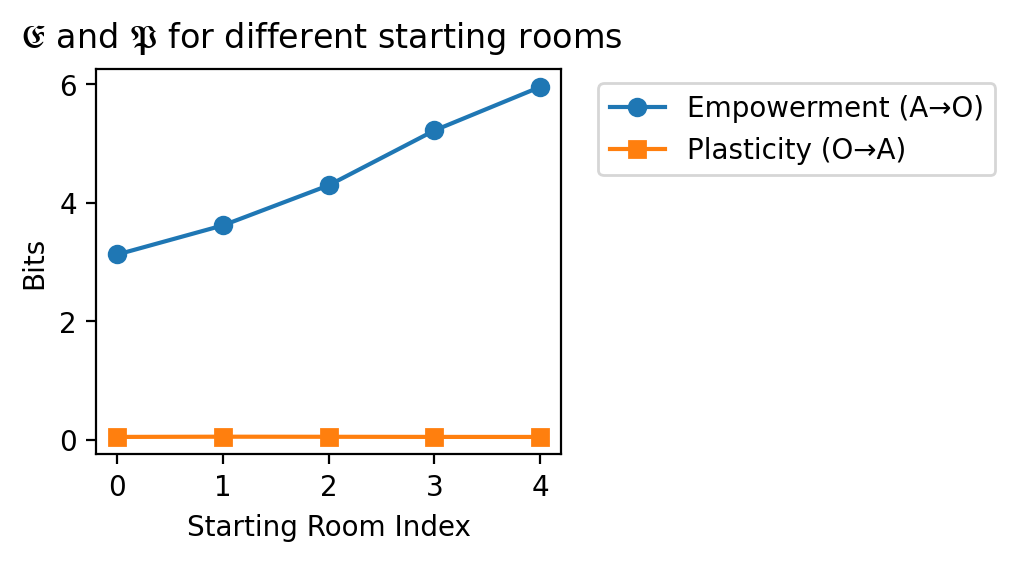

In [5]:
from src.environments.LightRooms import LightRooms
from experiments.measure_eachroom import collect_data_from_start_room, flatten_obs_seq

# --- Parameters ---
n_rooms = 4
seq_len = 10
num_samples = 10000
markov_k = 2
rng = np.random.default_rng(0)

# --- Experiment ---
empowerments = []
plasticities = []
env = LightRooms(n_rooms=n_rooms)

for room in tqdm(range(n_rooms + 1), desc="Measuring by room index"):
    a_seqs, o_seqs = collect_data_from_start_room(room, num_samples, seq_len, rng)
    o_seqs = flatten_obs_seq(o_seqs)
    emp = directed_info_approx_markov(a_seqs, o_seqs, k=markov_k)
    plast = directed_info_approx_markov(o_seqs, a_seqs, k=markov_k)
    empowerments.append(emp)
    plasticities.append(plast)

# --- Plotting ---
room_indices = list(range(n_rooms + 1))
plt.figure(figsize=(3, 2.5), dpi=200)
plt.plot(room_indices, empowerments, marker='o', label='Empowerment (A→O)')
plt.plot(room_indices, plasticities, marker='s', label='Plasticity (O→A)')
plt.xticks(room_indices, [int(i) for i in room_indices])
plt.xlabel('Starting Room Index')
plt.ylabel('Bits')
plt.suptitle(r'$\mathfrak{E}$ and $\mathfrak{P}$ for different starting rooms')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



I was concerned about whether just varying the start state would give a good enough look at the empowerment in that starting room. After all, the agent could wander to another room and spend a lot of its time there, contaminating our sequence.

Our:
* large sample size (1000 is enough for convergance of a 2nd order Markov Approximation of DI for an $X^{10}$, see Appendix D for more),
* combined with the brief duration of our episodes (sequences of length $T=10$),
* and some nice recurrence properties of the 1D random walk,

makes me think that we should still have enough lever pulls in the right room to give us a good enough peek at the differences in empowerment between starting rooms. I am not fully convinced by this though, so I may someday manually put the agent back into the starting room whenever it leaves. (Making the agent just pull the lever is useless because then $A^n = [2, 2, 2, \dots]$ and $O^n = [0, 1, 0, 1, \dots]$, and there directed information was always measured as 0).

To sanity check episode length part of my intuition, I increased the length of episodes. This would give the random agent enough time to mix around in rooms of all kinds, letting it visit enough other rooms to wash out any differences in empowerment caused by the starting room.

Sweeping seq len: 100%|██████████| 3/3 [00:20<00:00,  6.87s/it]


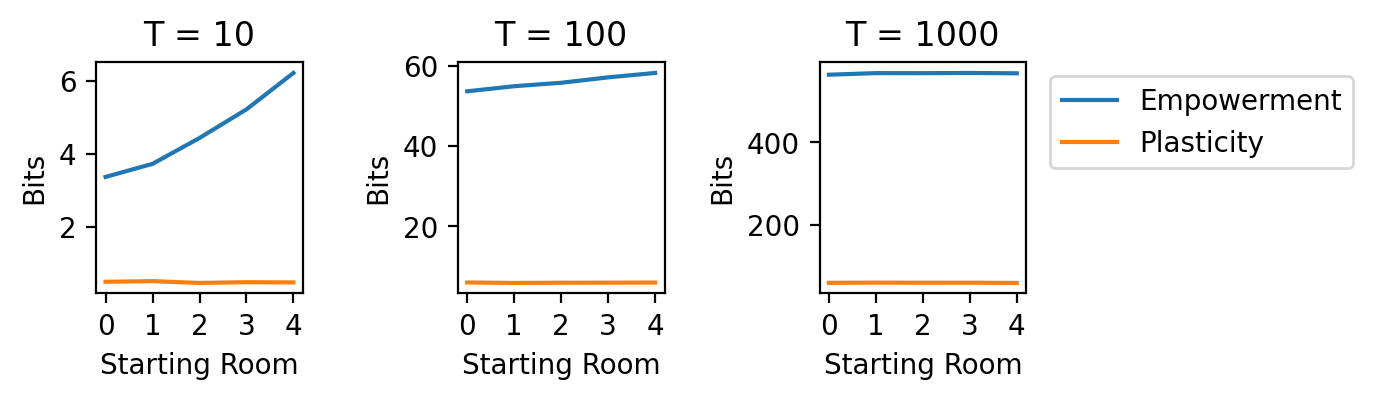

In [14]:
from experiments.measure_eachroom import sweep_seq_len

# --- Parameters ---
n_rooms = 4
seq_lens = [10, 100, 1000]
num_samples = 1000
markov_k = 2
rng = np.random.default_rng(0)

# --- Experiment ---
Emp_by_seq_len, Plast_by_seq_len = sweep_seq_len(n_rooms, seq_lens, num_samples, markov_k, rng)

# --- Plotting ---
room_indices = list(range(n_rooms + 1))
fig, axs = plt.subplots(1, 3, figsize=(6, 1.5), dpi=200)
for i, (T, E, P) in enumerate(zip(seq_lens, Emp_by_seq_len.values(), Plast_by_seq_len.values())):
    axs[i].plot(room_indices, E, label=f'Empowerment')
    axs[i].plot(room_indices, P, label=f'Plasticity')
    axs[i].set_ylabel('Bits')
    axs[i].set_xlabel('Starting Room')
    axs[i].set_title(f'T = {T}')
    axs[i].set_xticks(list(range(n_rooms+1)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.75)
plt.show()

Q2: Is there a way to compute the max possible empowerment in each room and plot that?

Q3: This above plot only used 1000 samples. Is that enough? Probably just for the left most plot. Bernoulli Sequences of length 100 needed ~65,000 samples when I was debugging my code in  Appendix C. But I should confirm this with a longer job here.

Q4: What would be the best way to demonstrate the actual tension between empowerement and plasticity here? The left room has the most information about the latent $X_t$ of the environment, so maybe an action set that affects $X_t$?

## 3. Next Steps
* An RL experiment! I was thinking a simple Q-learning in a GridWorld like FourRooms and measuring its return/reard, empowerment and plasticity as a function of episodes/training steps.
* Empirically measure the "conservation law" that I am still not convinced by.
* Write an algorithm for estimating GDI online.

---

## Appendix: Implementing functions from Information Theory

### A. Discrete Random Variables (DRVs)
I haven't formally worked with information theory before, so I started off by implementing some of the basic information theoretic quantities like entropy, joint entropy, conditional entropy and mutual information for just _discrete random variables_ with a tiny alphabet. Namely,

$$ X, Y \sim \text{Bernoulli}(0.5),$$

i.e. two coin tosses :D

Sample Sizes: 100%|██████████| 9/9 [00:00<00:00, 2243.34it/s]


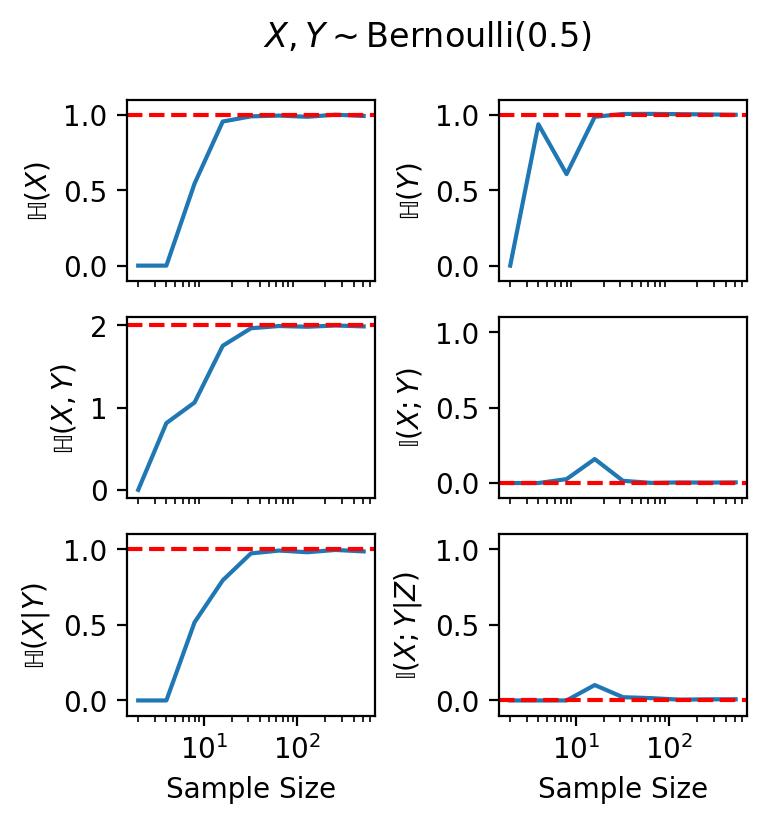

In [1]:
from experiments.it_diagnostic import drv_quantities
drv_quantities()

### B. Sequences of DRVs

Next, I moved on to sequences of discrete random variables. Initially I naively tried scaling up the same numerical methods from the single DRV setting:
1. Rollout a sequence of 100 coin tosses ($X^{100}$)
2. Do this a 1000 times to get 1000 samples of $X^{100}$ as our dataset $\mathcal{D}$
3. Compute $\text{Pr}(X^n)$ in a frequentist manner
4. Plug $\text{Pr}(X^n)$ into the entropy formula $\mathbb{H}(X^{100}) = - \sum_{X^{100} \in \mathcal{D}} \text{Pr}(X^{100}) \log_2(\text{Pr}(X^{100}))$

The problem here is that the space of all possible $X^{100}$ is HUGE (of size $2^{100}$ for the Bernoulli sequences I was working with)! So all sequences in $\mathcal{D}$ were unique, and $\text{Pr}(X^{100})$ always looked like a uniform distribution, with entropy $= \log_2(|\mathcal{D}|) = \log_2(1000) \approx 10 \, \text{bits}$.

So as I plotted this incorrect entropy as a function of $\log(\text{sample size})$, it went up linearly, instead of converging :`).

<img src="images/NaiveEntropySeq.png" alt="Incorrect entropy went up linearly with sample size :(" width="50%">

Side notes:
* Initially I tried using this undersampled entropy estimator straight away in the `LightRooms` env, but saw both plasticity and empowerment go up when a random agent entered rooms it could control better. This is when I knew there was a bug in my sequences code.
* I did find a less biased estimator of entropy than our current maximum liklihood estimator. It is called the _Miller-Madow correction term_ $\frac{m-1}{2n}$, where $m$ is the number of different values of $X$ present in the sequence, and it is added to our usual MLE of entropy. This did help imporved convergence in the DRV setting, but the undersampling error in the discrete random sequence setting was just too huge to fix with this term.

I was able to fix this using conditional entropies. Specifically, instead of trying to estimate a single 100-dimensional joint probability distribution, I tried estimating a 100 one-dimensional conditional probability distributions. By the **chain rule of probability**,
$$
\begin{align*}
\text{Pr}(X^n) &= \text{Pr}(X_1, \dots, X_n)\\
&= \text{Pr}(X_1) \times \text{Pr}(X_2|X_1) \times \text{Pr}(X_3|X_1, X_2) \times \dots \text{Pr}(X_n|X_1,\dots X_{n-1})\\
&= \prod_{t=1}^n \text{Pr}(X_t | X^{t-1}).
\end{align*}
$$

Where I use a short hand of $X^{t-1} = [X_1 \dots X_{t-1}]$. Plugging this into the definition of entropy, we get:
$$
\begin{align*}
\mathbb{H}(X^n) &= -\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \log\big(\text{Pr}(X^n)\big),\\
&= -\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \log\Bigg(\prod_{t=1}^n \text{Pr}(X_t | X^{t-1})\Bigg)\\
&= -\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \sum_{t=1}^n\log\big(\text{Pr}(X_t | X^{t-1})\big)\\
&= -\sum_{t=1}^n\sum_{X^n \in \mathcal{X}^n} \text{Pr}(X^n) \log\big(\text{Pr}(X_t | X^{t-1})\big)\\
&= \sum_{t=1}^n \mathbb{H}(X_t | X^{t-1}).\\
\end{align*}
$$

We arrive at the last line by the defintion of conditonal entropy, $\mathbb{H}(X|Y) = -\sum_{\mathcal{X, Y}} \text{Pr}(X, Y) \log(\text{Pr}(X|Y))$. In the codebase, `it.conditional_entropy_from_context()` computes each term of this summation, without ever having to estimate a multi-dimensional probability distribution 🎉 I _think_ this is what's normally done in the field to estimate the entropy of a sequence. We plot these for our sequences of Bernoulli(0.5) variables:

100%|██████████| 11/11 [00:00<00:00, 74.40it/s]


Text(0.5, 0, 'Sample Size')

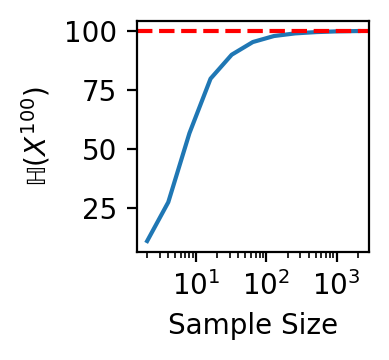

In [20]:
seq_length = 100
sizes = [2**i for i in range(1, 12)]
H_xseqs = []

for n in tqdm(sizes):
        x_seqs = [tuple(np.random.randint(0, 2, size=seq_length)) for _ in range(n)]
        H_xseqs.append(it.entropy_seq(x_seqs))

plt.figure(figsize=(1.5, 1.5), dpi=200)
plt.plot(sizes, H_xseqs)
plt.axhline(y=seq_length, color='r', linestyle='--')
plt.xscale('log')
plt.ylabel(r'$\mathrm{\mathbb{H}}(X^{%d})$' % seq_length)
plt.xlabel('Sample Size')

### C. Directed Information: Why & How I approximate it

The final, and arguably most important, information theoretic quantity I needed in order to investigate empowerment and plasticity is the *directed information* (DI) between two sequences of random variables:
$$
\mathbb{I}(X^n \rightarrow Y^n)  = \sum_{i=1}^n \mathbb{I}(X^i; Y_i | Y^{i-1}).
$$
This measures how much the values in the sequence $X^n$ influences the values in the sequence $Y^n$. It is a sum of mutual informations between a DRV and a sequence of DRVs, conditioned on another sequence of DRVs. We had implemented and plotted conditional mutual information of just DRVs in Appendix A, and will extend it here.

How do we compute each term of this sum? We can't just use `it.conditional_mutual_info` as in the DRV case, as estimating the joint distribution does not scale due to the curse of dimensionality on $X^n$, as we saw in Appendix B.

We shall deal with this in a similar manner, by pushing the sequences into the conditional and only working with DRVs. This will rely on the **chain rule for mutual information**, $\mathbb{I}(X, Y; Z) = \mathbb{I}(Y; Z) + \mathbb{I}(X | Y; Z)$, to our sequence $X^n$.

$$
\begin{align*}
\mathbb{I}(X^n; Y_n | Y^{n-1}) &= \mathbb{I}(X_n; Y_n | X^{n-1}, Y^{n-1}) + \mathbb{I}(X^{n-1}; Y_n | Y^{n-1})\\
&= \sum_{t=1}^n \mathbb{I}(X_{t}; Y_{n} | X^{t-1}, Y^{n-1}),
\end{align*}
$$
where the last line is from repeatedly applying the chain rule until we have just DRVs and no sequences before the conditional. Note that this sum was just for one term of the DI. For the complete DI,

$$
\mathbb{I}(X^n \rightarrow Y^n)  = \sum_{i=1}^n \sum_{t=1}^i \mathbb{I}(X_{t}; Y_{i} | X^{t-1}, Y^{i-1}).
$$

Once again, let's now run this on our humble pair of Bernoulli sequences, which we could think of as bytes. I expect to see $\mathbb{I}(X^8 \rightarrow Y^8) = 0$, as $X^8$ has no influence on $Y^8$.

100%|██████████| 21/21 [01:28<00:00,  4.19s/it]


Text(0.5, 0, 'Sample Size')

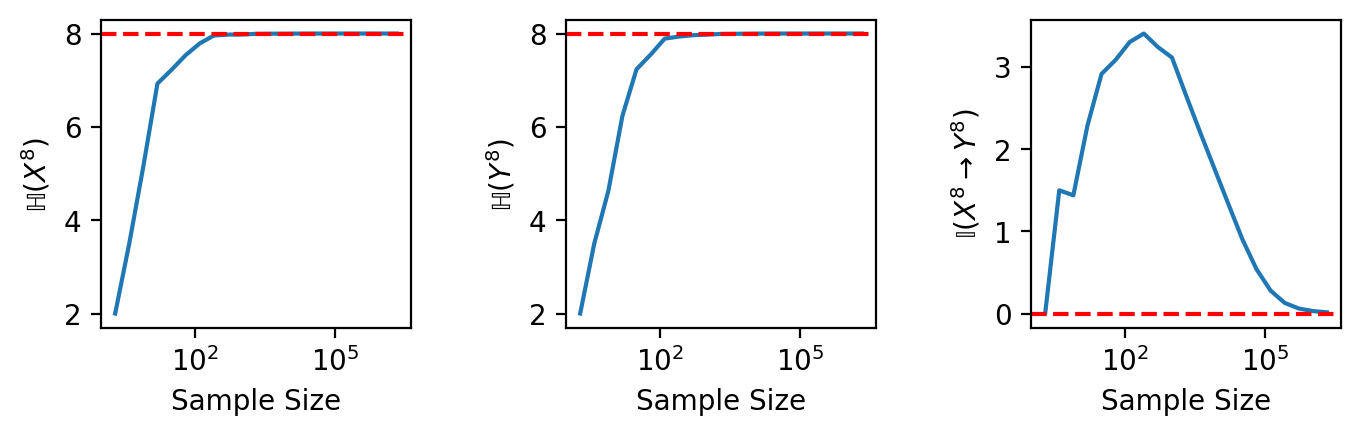

In [42]:
seq_length = 8
sizes = [2**i for i in range(1, 22)]
H_xseqs = []
H_yseqs = []
DI_xseq_yseqs = []

for n in tqdm(sizes):
    x_seqs = [tuple(np.random.randint(0, 2, size=seq_length)) for _ in range(n)]
    y_seqs = [tuple(np.random.randint(0, 2, size=seq_length)) for _ in range(n)]

    H_xseqs.append(it.entropy_seq(x_seqs))
    H_yseqs.append(it.entropy_seq(y_seqs))
    DI_xseq_yseqs.append(it.directed_info_approx_markov(x_seqs, y_seqs, k=seq_length))

fig, axs = plt.subplots(1, 3, figsize=(8, 2), dpi=200)
plt.subplots_adjust(wspace=0.5)

axs[0].plot(sizes, H_xseqs)
axs[0].axhline(y=seq_length, color='r', linestyle='--')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$\mathrm{\mathbb{H}}(X^{%d})$' % seq_length)
axs[0].set_xlabel('Sample Size')

axs[1].plot(sizes, H_yseqs)
axs[1].axhline(y=seq_length, color='r', linestyle='--')
axs[1].set_xscale('log')
axs[1].set_ylabel(r'$\mathrm{\mathbb{H}}(Y^{%d})$' % seq_length)
axs[1].set_xlabel('Sample Size')

axs[2].plot(sizes, DI_xseq_yseqs)
axs[2].axhline(y=0, color='r', linestyle='--')
axs[2].set_xscale('log')
axs[2].set_ylabel(r'$\mathrm{\mathbb{I}}(X^{%d} \rightarrow Y^{%d})$' % (seq_length, seq_length))
axs[2].set_xlabel('Sample Size')

That took a lot of samples! About $2^{21} \approx 2 \, \text{million}$.
The way I think of this result: even for two uncorrleated sequences of length 8, it takes many many samples to weed out all possible causal models, and for this to be reflected in the DI, $\mathbb{I}(X^{8} \rightarrow Y^{8})$. Exactly estimating the DI this way, even with conditional distributions, takes far too many samples! This led me to look into ways to approximate DI.

Looking at the $\mathbb{I}(X_{t}; Y_{t} | X^{t-1}, Y^{t-1})$ term, the conditionals do not scale well to longer sequences. It would require many samples to determine if whether any $X_i$ or $Y_i$ values since the beginning of time in our system had an influence on the mutual infoirmation of the most recent $X_t$ and $Y_t$. The simplest way to get rid off this dependence would be to not look back until the beginning of time, but only a fixed window of size $k$,

$$
\begin{align*}
\mathbb{I}(X^n \rightarrow Y^n) &\approx \mathbb{I}_k(X^n \rightarrow Y^n)\\
&= \sum_{i=1}^n \sum_{t=1}^i \mathbb{I}(X_{t}; Y_{i} | X_{t-k:t-1}, Y_{i-k:i-1}),
\end{align*}
$$

where $X_{t-k:t-1} = [X_{t-k} \dots X_{t-1}]$. This would only detect influences from $X_i$'s in this $k$-length window on $Y_i$'s in this window. This will converge to an estimate of the true DI if our system is at most $k^{\text{th}}$ order Markov.

100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Text(0.5, 0, 'Sample Size')

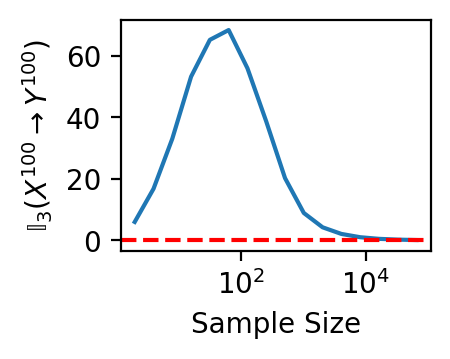

In [41]:
seq_length = 100
k = 3
sizes = [2**i for i in range(1, 17)]
DI_xseq_yseqs = []

for n in tqdm(sizes):
    x_seqs = [tuple(np.random.randint(0, 2, size=seq_length)) for _ in range(n)]
    y_seqs = [tuple(np.random.randint(0, 2, size=seq_length)) for _ in range(n)]
    DI_xseq_yseqs.append(it.directed_info_approx_markov(x_seqs, y_seqs, k))

plt.figure(figsize=(2, 1.5), dpi=200)
plt.plot(sizes, DI_xseq_yseqs)
plt.axhline(y=0, color='r', linestyle='--')
plt.xscale('log')
plt.ylabel(r'$\mathrm{\mathbb{I}_{%d}}(X^{%d} \rightarrow Y^{%d})$' % (k, seq_length, seq_length))
plt.xlabel('Sample Size')

Notice how this let us approximate the DI between two sequences of length 100 in about $2^{16} \approx 65,000$ samples, albeit only for 3rd order influences. This window size $k$ dictates our use cases and the scope of the claims we can make with these empirical measurements. Nonetheless, it is a useful tool if we need to deal with longer sequences. Hopefully when I implement Generalised DI, the sequence segments $X_{a:b}$ and $Y_{c:d}$ are small enough to use a decent $k$, if not the full segments.

### D. An interesting finding with $k^{\text{th}}$ order Markov Approximations of Conditioned Quantities

An interesting phenomenon from the last experiment is the shape of the peak we observe. We know by definition that $\mathbb{I}(X^n \rightarrow Y^n) = 0$, but the spike in error in the under-sampled regime is still fascinating. I wanted to see how $k$ affects this spike, and whether my intuition for lower order approximations converging _more easily_ (i.e. with fewer samples) is true.

100%|██████████| 6/6 [01:06<00:00, 11.17s/it]


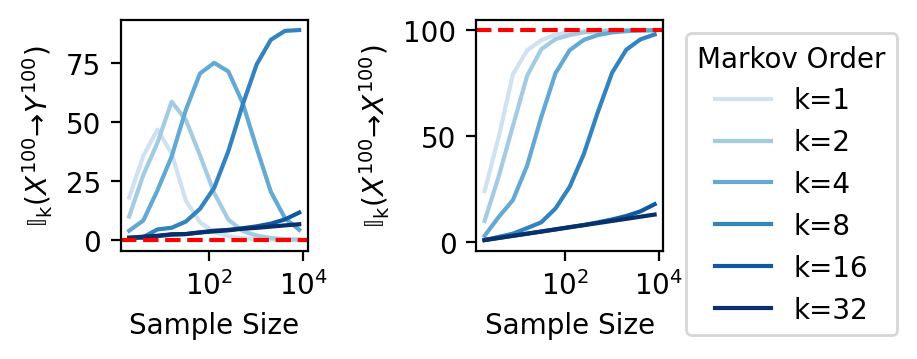

In [2]:
from experiments.it_diagnostic import sweep_k
sweep_k()

TODO: talk about how you've used the kth order approx in conditional entropy calculations too